#### Install and setup dependecies

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [2]:
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.2
Keras Version: 2.9.0

Python 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:05:16) 
[Clang 12.0.1 ]
Pandas 1.4.3
Scikit-Learn 1.1.2
GPU is available


In [3]:
import os

In [4]:
os.path.join('data','happy')

'data/happy'

In [5]:
# avoid oom erros by stting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#### Data Claning

In [6]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [7]:
data_dir = 'Data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    if image_class != '.DS_Store':
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)

#### Data Load

In [10]:
 tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 263 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-10 14:47:47.830110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-10 14:47:47.830607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
data_iterator = data. as_numpy_iterator()

In [15]:
data_iterator

In [16]:
#get batch from iterator
batch = data_iterator.next()

2022-10-10 14:47:48.082361: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
#image represent as numpy array
batch[0].shape

(32, 256, 256, 3)

In [18]:
# class 1 = fat, class 2 = normal
batch[1]

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

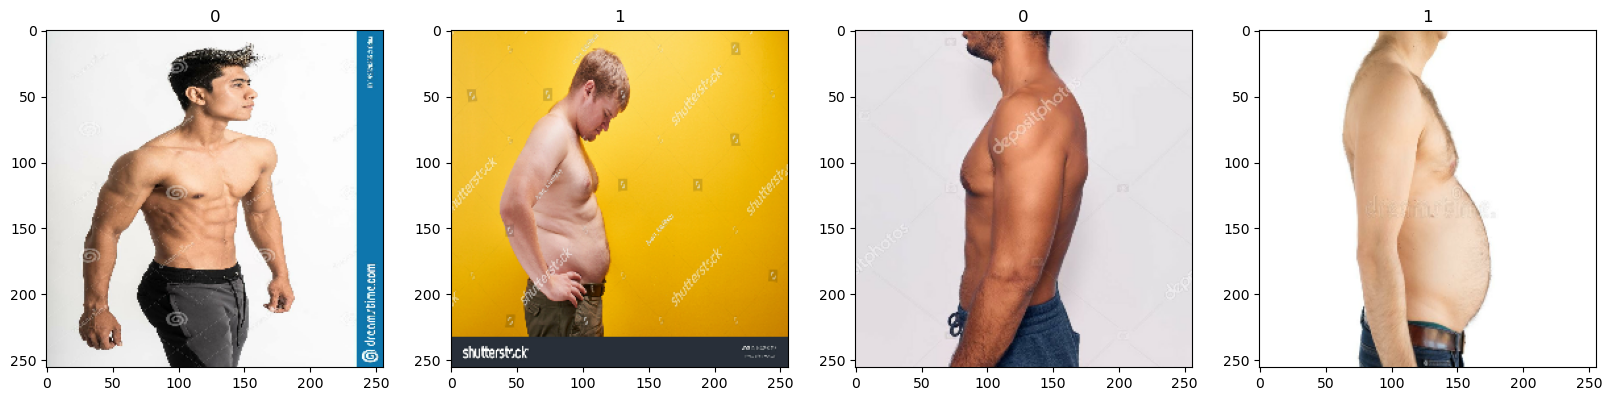

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [20]:
batch[0].shape

(32, 256, 256, 3)

In [21]:
batch[0].min()

0.0

In [22]:
batch[0].max()

255.0

In [23]:
scaled = batch[0]/255

In [24]:
scaled.max()

1.0

#### Preprocess data

In [25]:
data= data.map(lambda x,y: (x/255, y))

In [26]:
scaled_iterator = data.as_numpy_iterator()

In [27]:
batch = scaled_iterator.next()

In [28]:
batch[0].max()

1.0

#### Split data

In [29]:
len(data)

9

In [30]:
train_size = int(len(data)*.7) ##3
val_size = int(len(data)*.2)+1 #2
test_size = int(len(data)*.1)+1 #1
print(train_size,val_size,test_size)

6 2 1


In [31]:
train = data.take(3)
val = data.skip(3).take(2)
test = data.skip(train_size+val_size).take(test_size)

In [32]:
plot_confusion_matrix(clf, X_test, y_test)  
>>> plt.show()


NameError: name 'plot_confusion_matrix' is not defined

#### Deep model

#### Build deep learning model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [36]:
model = Sequential()

In [37]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [38]:
model.compile(
            'adam', 
            loss=tf.losses.BinaryCrossentropy(), 
            metrics=[
                    tf.keras.metrics.BinaryAccuracy(),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall()
            ])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### Train

In [40]:
logdir = 'log'

In [41]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [47]:
hist = model.fit(train, epochs=60, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/60
3/3 [==============================] - 2s 422ms/step - loss: 0.2044 - binary_accuracy: 0.9479 - precision: 0.9778 - recall: 0.9167 - val_loss: 0.3223 - val_binary_accuracy: 0.8906 - val_precision: 0.9167 - val_recall: 0.8919
Epoch 2/60
3/3 [==============================] - 1s 414ms/step - loss: 0.2322 - binary_accuracy: 0.8750 - precision: 0.8696 - recall: 0.8696 - val_loss: 0.1665 - val_binary_accuracy: 0.9531 - val_precision: 0.9655 - val_recall: 0.9333
Epoch 3/60
3/3 [==============================] - 1s 382ms/step - loss: 0.2612 - binary_accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - val_loss: 0.2703 - val_binary_accuracy: 0.8906 - val_precision: 0.8718 - val_recall: 0.9444
Epoch 4/60
3/3 [==============================] - 1s 395ms/step - loss: 0.1519 - binary_accuracy: 0.9479 - precision: 0.9348 - recall: 0.9556 - val_loss: 0.2617 - val_binary_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7576
Epoch 5/60
3/3 [==============================] - 1s 381

#### plot performance

#### Eveluate performance

In [50]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [51]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [55]:
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

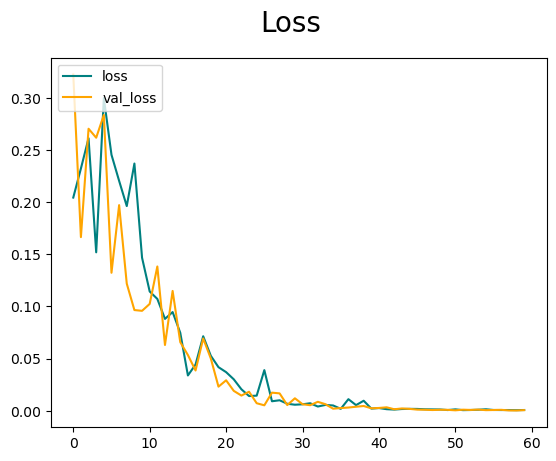

In [76]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

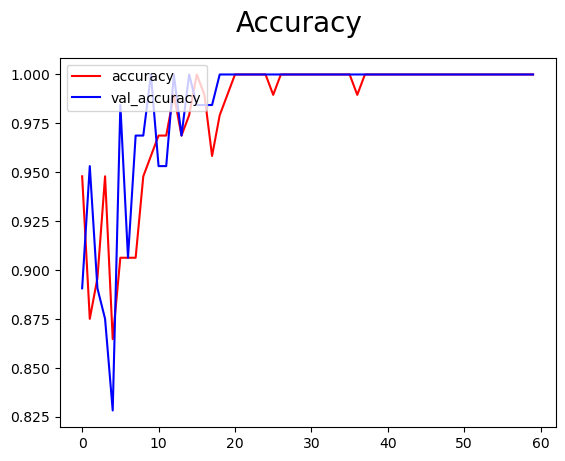

In [75]:
fig = plt.figure()
plt.plot(hist.history['binary_accuracy'],color='red', label='accuracy')
plt.plot(hist.history['val_binary_accuracy'],color='blue', label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

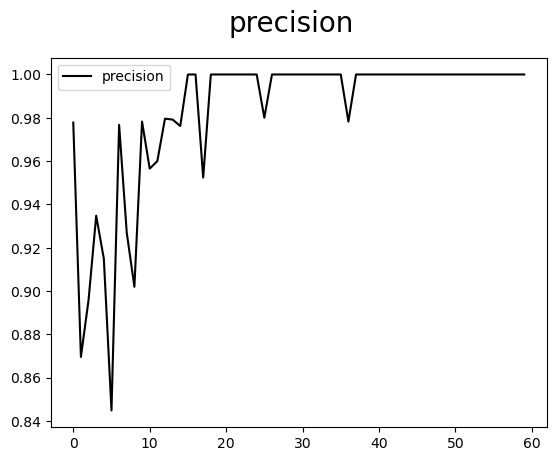

In [74]:
fig = plt.figure()
plt.plot(hist.history['precision'], color='black', label='precision')
fig.suptitle('precision',fontsize=20)
plt.legend(loc='upper left')
plt.show()

1/1 [==============================] - 0s 37ms/step


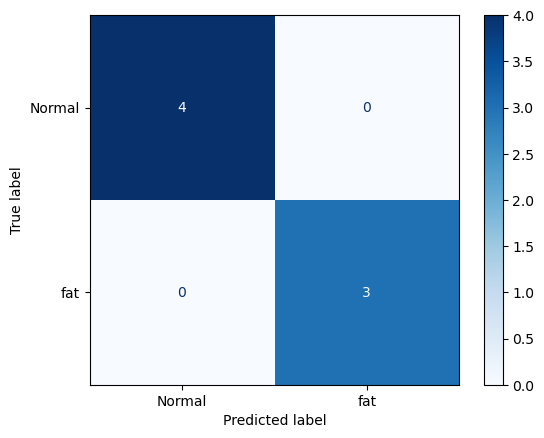

In [73]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    labels = ["Normal", "fat"]
    cm = confusion_matrix(y, np.round(yhat))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [46]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 1.0, Recall:1.0, Accuracy:1.0


In [43]:
#confusion matrix for model evaluation
# Importing needed libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Defining list with labels
labels = ['Fat', 'Slim']

#### Test

In [47]:
img = cv2.imread('Data/normal/1-1.jpg')
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [48]:
# os.listdir(os.getcwd() + '/Data/Normal')

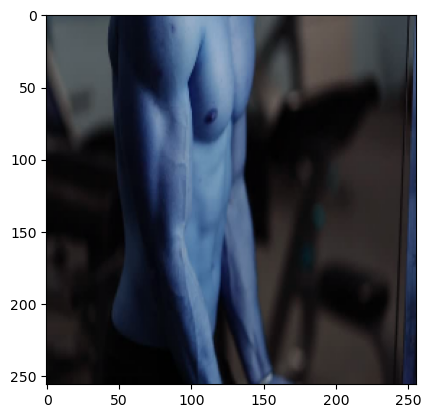

In [49]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [50]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 1s 514ms/step


In [51]:
yhat

array([[0.02116784]], dtype=float32)

In [52]:
if yhat > 0.5:
    print("Fat")
else:
    print("Slim")

Slim


In [53]:
from tensorflow.keras.models import load_model

In [56]:
model.save(os.path.join('models','slimfatmodel1.h5'))

In [57]:
new_model =load_model(os.path.join('models','slimfatmodel1.h5'))